# 对抗样本问题

深度神经网络（DNN）已经在图像处理、文本分析和语音识别等各种应用领域取得了很大的进展。DNN 也是很多网络与实体相连接的系统（cyber-physical system）的重要组成部分。比如说，自动驾驶汽车的视觉系统可以利用 DNN 来更好地识别行人、车辆和道路标志。但是，近来的研究表明 DNN 容易受到对抗样本（adversarial example）的影响：在输入中加入精心设计的对抗扰动（adversarial perturbation）可以误导目标 DNN，使其在运行中给该输入加标签时出错。当在实际世界中应用 DNN 时，这样的对抗样本就会带来安全问题。比如，加上了对抗扰动的输入可以误导自动驾驶汽车的感知系统，使其在分类道路标志时出错，从而可能造成灾难性的后果。

## 1. 预训练的Lenet网络

### 1.1. 测试数据集准备

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
    ])),
    batch_size=1, shuffle=True
)

### 1.2. Lenet预训练模型加载

In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(x), 2))

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model = LeNet().to(device)
model.load_state_dict(torch.load("./checkpoints/lenet_mnist_model.pth", map_location='cpu'))
model.eval()

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### 1.3. 测试模型性能

In [11]:
def test(model, device, test_loader):
    # Accuracy counter
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        out_pred = output.max(1, keepdim=True)[1]
        
        if out_pred.item() == target.item():
            correct += 1
    
    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))

    # Return the accuracy
    return final_acc
            
final_acc = test(model, device, test_loader)
print("final_accuracy: {}".format(final_acc))

final_accuracy: 0.981


## 2. 对LeNet添加FGSM攻击

In [1]:
"""
白盒与黑盒
白盒的意思为：在已经获取机器学习模型内部的所有信息和参数上进行攻击
盒黑的意思为：在神经网络结构为黑箱时，仅通过模型的输入和输出，逆推生成对抗样本。
误分类 和 目标误分类
误分类的意思是：不关心输出的分类是否存在，只要不与原分类相同即可
目标误分类的意思是：规定检测出来的类别需要与给定的一致
"""

"""
Fast Gradient Sign Attack（FGSM）
FGSM是一种简单的对抗样本生成算法，该算法的思想直观来看就是在输入的基础上沿损失函数的梯度方向加入了一定的噪声，使目标模型产生了误判
公式如下：
perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))
"""

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./checkpoints/lenet_mnist_model.pth"
use_cuda=True

### 2.1. 测试数据集准备

In [2]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
    ])),
    batch_size=1, shuffle=True
)

### 2.2. 预训练模型加载

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(x), 2))

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model = LeNet().to(device)
model.load_state_dict(torch.load("./checkpoints/lenet_mnist_model.pth", map_location='cpu'))
model.eval()

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### 2.3. 添加FGSM攻击

In [4]:
# -------------定义对抗图片生成函数---------------
def fgsm_attack(image, epsilon, data_grad):
    """
    获取扰动图片
    :param image: 原始图片
    :param epsilon: 扰动量
    :param data_grad: 损失梯度
    :return:
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image
# ---------------------------------------------

### 2.4. 测试模型性能

In [5]:
# -------------定义测试函数---------------------
def fgsm_test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        # loss
        loss = F.nll_loss(output, target) # 用于多分类的负对数似然损失函数（Negative Log Likelihood) loss(x,label)=−xlabel

        model.zero_grad()

        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
# ---------------------------------------------

In [7]:
# ---------------------开始测试-----------------
accuracies = []
examples = []
for eps in epsilons:
    acc, ex = fgsm_test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


### 2.5. 结果展示

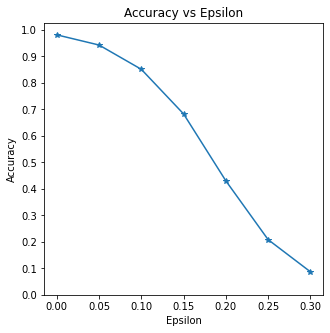

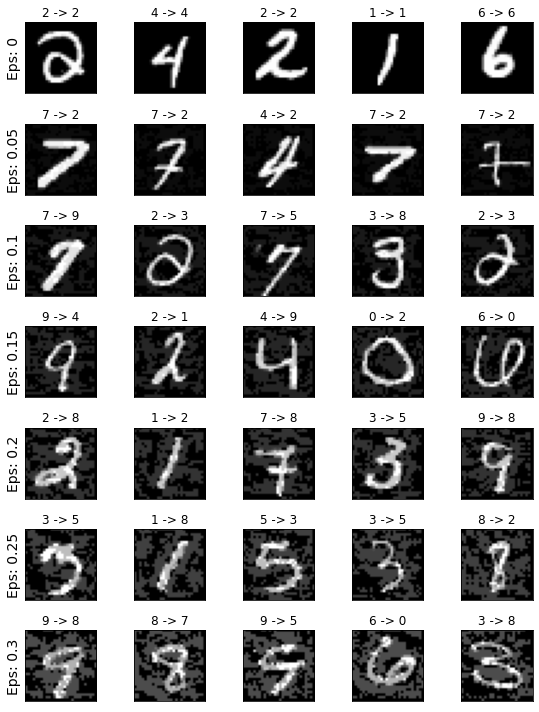

In [8]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()
# ---------------------------------------------

## 3. ResNet的FGSM攻击

In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

input_size = 224
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = './checkpoints/resnet50-19c8e357.pth'
use_cuda=True

### 3.1. 测试数据集准备

In [4]:
data_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data/', train=False, download=False, transform=data_transforms),
    batch_size=1, shuffle=True
)

### 3.2. 预训练模型加载

In [5]:
import torchvision.models as models

class ImagenetTransferLearning(nn.Module):
    def __init__(self):
        super().__init__()

        # init a pretrained resnet
        backbone = models.resnet50(pretrained=False)
        backbone.load_state_dict(torch.load('./checkpoints/resnet50-19c8e357.pth'))
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify cifar-10 (10 image classes)
        num_target_classes = 10
        self.classifier = nn.Linear(num_filters, num_target_classes)

    def forward(self, x):
        self.feature_extractor.eval()
        representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x
    
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model = ImagenetTransferLearning()
model = model.to(device)
model.load_state_dict(torch.load('./checkpoints/resnet.ckpt', map_location='cpu'))
model.eval()

ImagenetTransferLearning(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

### 3.3. 添加FGSM攻击

In [6]:
# -------------定义对抗图片生成函数---------------
def fgsm_attack(image, epsilon, data_grad):
    """
    获取扰动图片
    :param image: 原始图片
    :param epsilon: 扰动量
    :param data_grad: 损失梯度
    :return:
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image
# ---------------------------------------------

### 3.4. 测试模型性能

In [9]:
# -------------定义测试函数---------------------
def fgsm_test(model, device, test_loader, epsilon, num_loader = 1000):
    # Accuracy counter
    correct = 0
    adv_examples = []
    
    if num_loader > len(test_loader):
        num_loader = len(test_loader)

    for i, (data, target) in enumerate(test_loader):
        if i % 100 == 0:
            print("{}/{} ↓".format(i, num_loader))
        
        if i > num_loader:
            break

        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        # loss
        loss = F.nll_loss(output, target) # 用于多分类的负对数似然损失函数（Negative Log Likelihood) loss(x,label)=−xlabel

        model.zero_grad()

        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(num_loader)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, num_loader, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
# ---------------------------------------------

In [10]:
# ---------------------开始测试-----------------
accuracies = []
examples = []
for eps in epsilons:
    acc, ex = fgsm_test(model, device, test_loader, eps, 1000)
    accuracies.append(acc)
    examples.append(ex)

0/1000 ↓
100/1000 ↓
200/1000 ↓
300/1000 ↓
400/1000 ↓
500/1000 ↓
600/1000 ↓
700/1000 ↓
800/1000 ↓
900/1000 ↓
1000/1000 ↓
Epsilon: 0	Test Accuracy = 341 / 1000 = 0.341
0/1000 ↓
100/1000 ↓
200/1000 ↓
300/1000 ↓
400/1000 ↓
500/1000 ↓
600/1000 ↓
700/1000 ↓
800/1000 ↓
900/1000 ↓
1000/1000 ↓
Epsilon: 0.05	Test Accuracy = 220 / 1000 = 0.22
0/1000 ↓
100/1000 ↓
200/1000 ↓
300/1000 ↓
400/1000 ↓
500/1000 ↓
600/1000 ↓
700/1000 ↓
800/1000 ↓
900/1000 ↓
1000/1000 ↓
Epsilon: 0.1	Test Accuracy = 209 / 1000 = 0.209
0/1000 ↓
100/1000 ↓
200/1000 ↓
300/1000 ↓
400/1000 ↓
500/1000 ↓
600/1000 ↓
700/1000 ↓
800/1000 ↓
900/1000 ↓
1000/1000 ↓
Epsilon: 0.15	Test Accuracy = 188 / 1000 = 0.188
0/1000 ↓
100/1000 ↓
200/1000 ↓
300/1000 ↓
400/1000 ↓
500/1000 ↓
600/1000 ↓
700/1000 ↓
800/1000 ↓
900/1000 ↓
1000/1000 ↓
Epsilon: 0.2	Test Accuracy = 180 / 1000 = 0.18
0/1000 ↓
100/1000 ↓
200/1000 ↓
300/1000 ↓
400/1000 ↓
500/1000 ↓
600/1000 ↓
700/1000 ↓
800/1000 ↓
900/1000 ↓
1000/1000 ↓
Epsilon: 0.25	Test Accuracy = 155 / 1000 =

### 3.5. 结果展示

In [11]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

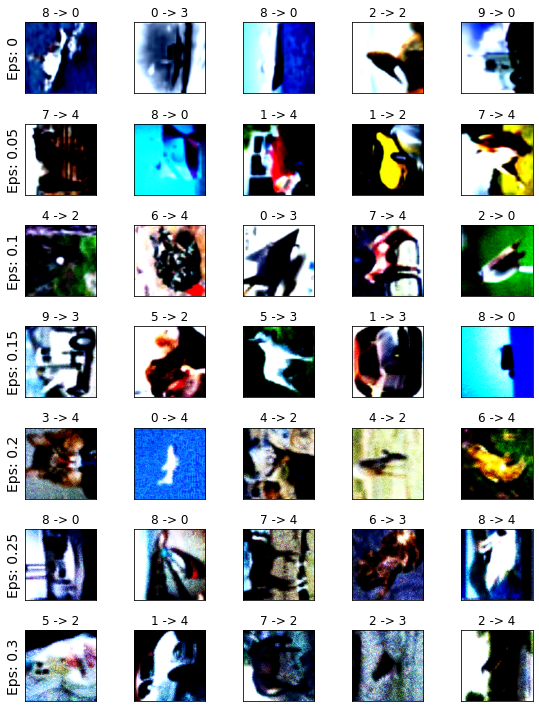

In [13]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.T, cmap="gray")
plt.tight_layout()
plt.show()
# ---------------------------------------------